In [7]:
import sys

sys.path.append('../')

import compiler_opt.tools.feature_importance_graphs as figraphs

In [8]:
shap_stuff = figraphs.load_shap_values('../explaination_data.json')

In [9]:
figraphs.init_shap_for_notebook()

In [10]:
figraphs.graph_individual_example(shap_stuff, index=0)

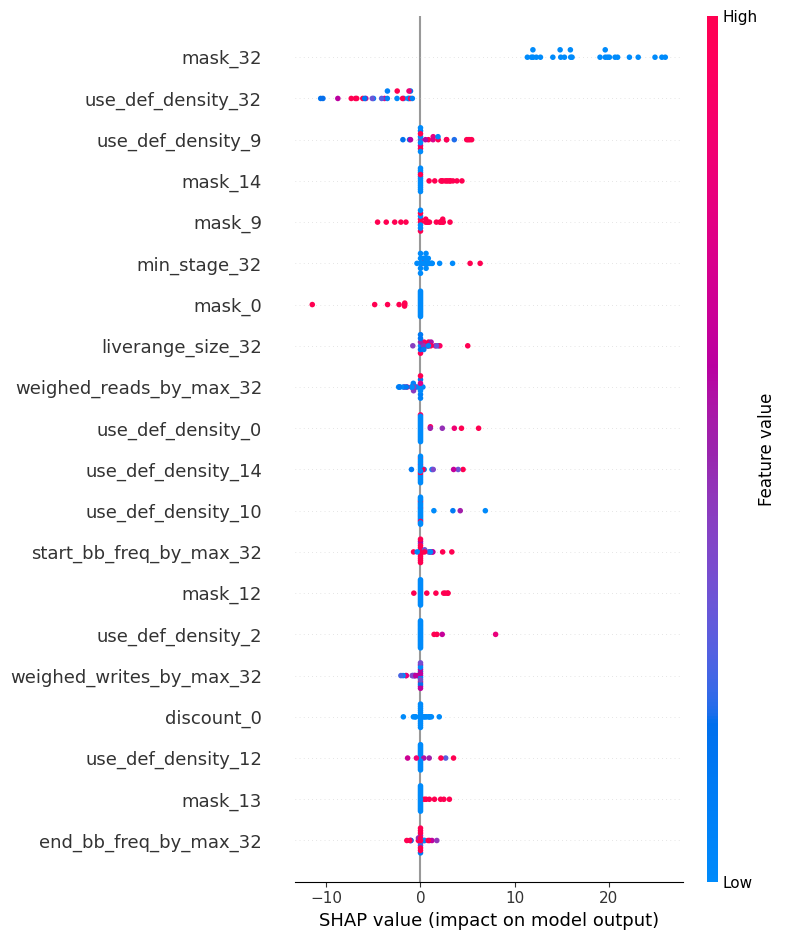

In [11]:
figraphs.graph_summary_plot(shap_stuff)